<a href="https://colab.research.google.com/github/Oxshadha/Bio-Fusion/blob/main/ModelConvext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gastric Cancer Histopathology Tissue Classification using ConvNeXt-Base

## Project Overview

This notebook implements a deep learning solution for automated classification of gastric cancer histopathology tissue images into 8 distinct tissue types. The model uses **ConvNeXt-Base**, a modern convolutional neural network architecture, pretrained on ImageNet and fine-tuned for histopathology image classification.

---

## Table of Contents

1. [Problem Definition](#1-problem-definition)
2. [Dataset Documentation](#2-dataset-documentation)
3. [Model Initialization & Pretraining Disclosure](#3-model-initialization--pretraining-disclosure)
4. [Model Development](#4-model-development)
5. [Training Process](#5-training-process)
6. [Outputs & Logs](#6-outputs--logs)
7. [Performance Metrics](#7-performance-metrics)
8. [Reproducibility](#8-reproducibility)
9. [Final Model](#9-final-model)
10. [Conclusion](#10-conclusion)


# 1. Problem Definition

## 1.1 Clinical/Healthcare Relevance

**Gastric cancer** (stomach cancer) is the **fifth most common cancer** and **third leading cause of cancer-related deaths** worldwide. Early and accurate diagnosis is crucial for effective treatment and improved patient outcomes.

### Current Diagnostic Challenges:

1. **Manual Histopathology Analysis**: Pathologists manually examine tissue slides under microscopes, which is:
   - Time-consuming (can take hours per case)
   - Subjective (inter-observer variability)
   - Resource-intensive (requires highly trained specialists)

2. **Tissue Microenvironment Complexity**: Gastric cancer tissue contains multiple components (tumor, stroma, lymphocytes, etc.) that must be accurately identified for:
   - Accurate staging
   - Treatment planning
   - Prognosis assessment

3. **Growing Demand**: With increasing cancer cases, there's a need for:
   - Faster diagnosis
   - Consistent, reproducible results
   - Scalable solutions

## 1.2 What is Being Predicted?

This model classifies histopathology tissue images into **8 distinct tissue types**:

- **ADI**: Adipose (fat tissue)
- **DEB**: Debris (cellular waste)
- **LYM**: Lymphocytes (immune cells)
- **MUC**: Mucus (protective secretion)
- **MUS**: Smooth Muscle (muscle tissue)
- **NOR**: Normal Colon Mucosa (healthy tissue)
- **STR**: Cancer-associated Stroma (connective tissue around tumor)
- **TUM**: Tumor epithelium (cancerous tissue)

### Clinical Significance:

- **Tumor (TUM)** identification is critical for cancer detection
- **Lymphocytes (LYM)** and **Stroma (STR)** indicate immune response and tumor microenvironment
- Accurate classification enables:
  - Automated tissue quantification
  - Tumor-Stroma Ratio (TSR) calculation
  - Tumor-Infiltrating Lymphocyte (TIL) scoring
  - Objective, reproducible tissue analysis

## 1.3 Why Deep Learning?

Deep learning models can:
- **Process large volumes** of histopathology images quickly
- **Learn complex patterns** in tissue morphology
- **Provide consistent** classifications (reducing inter-observer variability)
- **Scale** to handle increasing diagnostic demands
- **Assist pathologists** by providing second opinions and highlighting regions of interest


# 2. Dataset Documentation

## 2.1 Full Citation

**Dataset**: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)

**Citation**:
```
Shenghan Lou, Jianxin Ji, Xuan Zhang, Huiying Li, Yang Jiang, Menglei Hua,
Kexin Chen, Xiaohan Zheng, Qi Zhang, Peng Han, Lei Cao, & Liuying Wang. (2024).
Gastric Cancer Histopathology Tissue Image Dataset (GCHTID) [Data set].
figshare. https://doi.org/10.6084/m9.figshare.26014469.v
```

**Original Publication**:
- Nature Scientific Data: https://www.nature.com/articles/s41597-025-04489-9

**Dataset Source**:
- Kaggle: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset
- Figshare DOI: https://doi.org/10.6084/m9.figshare.26014469.v

**License**: Creative Commons Attribution 4.0 International (CC BY 4.0)

## 2.2 Variables/Labels Description

The dataset contains **31,096 histopathology tissue images** extracted from **300 whole slide images** obtained from Harbin Medical University Cancer Hospital.

### Image Characteristics:
- **Size**: 224×224 pixels
- **Format**: RGB (3 channels)
- **Source**: H&E-stained pathological slides
- **Extraction**: Non-overlapping tiles from whole slide images

### Class Labels (8 tissue types):

| Class | Code | Description | Clinical Significance |
|-------|------|-------------|----------------------|
| Adipose | ADI | Fat tissue | Normal tissue component |
| Debris | DEB | Cellular waste | Background/non-tissue |
| Lymphocytes | LYM | Immune cells | Immune response indicator |
| Mucus | MUC | Protective secretion | Normal mucosal component |
| Smooth Muscle | MUS | Muscle tissue | Normal tissue component |
| Normal Mucosa | NOR | Healthy tissue | Reference for comparison |
| Stroma | STR | Connective tissue around tumor | Tumor microenvironment |
| Tumor | TUM | Cancerous tissue | **Primary target for detection** |

## 2.3 Data Distribution & Basic Analysis

We will analyze the class distribution to understand dataset balance and potential biases.


In [1]:
# Install required packages
!pip install -q timm opencv-python kaggle

# Mount Google Drive (optional, for saving models)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Setup Kaggle API (upload kaggle.json file)
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json

# Configure Kaggle
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✓ Kaggle API configured")


Saving kaggle.json to kaggle.json
✓ Kaggle API configured


In [3]:
# Download and extract dataset
print("Downloading dataset from Kaggle...")
print("Dataset: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)")
print("Source: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset")
print()

!kaggle datasets download -d orvile/gastric-cancer-histopathology-tissue-image-dataset

print("\nExtracting dataset...")
!unzip -q gastric-cancer-histopathology-tissue-image-dataset.zip -d GCHTID

print("✓ Dataset downloaded and extracted to /content/GCHTID")
print(f"Dataset path: /content/GCHTID/HMU-GC-HE-30K/all_image")


Dataset: Gastric Cancer Histopathology Tissue Image Dataset (GCHTID)
Source: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset

Dataset URL: https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 3.01G/3.03G [00:42<00:00, 243MB/s]
100% 3.03G/3.03G [00:42<00:00, 75.7MB/s]

Extracting dataset...
✓ Dataset downloaded and extracted to /content/GCHTID
Dataset path: /content/GCHTID/HMU-GC-HE-30K/all_image


In [5]:
# ============================================================================
# IMPORT ALL REQUIRED LIBRARIES
# ============================================================================
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, matthews_corrcoef
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json
import cv2
import timm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION CONSTANTS
# ============================================================================
DATASET_PATH = "/content/GCHTID/HMU-GC-HE-30K/all_image"
CLASSES = ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}
RANDOM_SEED = 42
BATCH_SIZE = 32
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ============================================================================
# REPRODUCIBILITY
# ============================================================================
def set_seeds(seed=RANDOM_SEED):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# ============================================================================
# DEVICE SETUP
# ============================================================================
def get_device():
    """Get the best available device (CUDA > MPS > CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device("mps")
        print("✓ Using MPS (Apple Silicon)")
    else:
        device = torch.device("cpu")
        print("⚠ Using CPU")
    return device

# ============================================================================
# FOCAL LOSS
# ============================================================================
class FocalLoss(nn.Module):
    """Focal Loss with Label Smoothing for addressing hard examples"""
    def __init__(self, alpha=0.25, gamma=2.0, label_smoothing=0.1, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        num_classes = inputs.size(1)
        if self.label_smoothing > 0:
            targets_one_hot = torch.zeros_like(inputs)
            targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
            targets_one_hot = targets_one_hot * (1 - self.label_smoothing) + self.label_smoothing / num_classes
            log_probs = F.log_softmax(inputs, dim=1)
            pt = torch.sum(targets_one_hot * torch.exp(log_probs), dim=1)
            ce_loss = -torch.sum(targets_one_hot * log_probs, dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ============================================================================
# CLAHE TRANSFORM
# ============================================================================
class CLAHETransform:
    """CLAHE (Contrast Limited Adaptive Histogram Equalization) transform"""
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        img_np = np.array(img)
        if len(img_np.shape) == 3:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            img_np[:, :, 0] = clahe.apply(img_np[:, :, 0])
            img_np = cv2.cvtColor(img_np, cv2.COLOR_LAB2RGB)
        else:
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_np = clahe.apply(img_np)
        return Image.fromarray(img_np)

# ============================================================================
# DATASET CLASS
# ============================================================================
class HistopathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# ============================================================================
# TRANSFORMS
# ============================================================================
def get_transforms(augment=True, use_clahe=True):
    """Get data transforms (with or without augmentation)"""
    transform_list = []
    if use_clahe:
        transform_list.append(CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)))
    if augment:
        transform_list.extend([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    else:
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    return transforms.Compose(transform_list)

# ============================================================================
# DATASET LOADING
# ============================================================================
def load_dataset_paths(dataset_root=DATASET_PATH):
    """Load all image paths and labels"""
    image_paths = []
    labels = []
    for class_name in CLASSES:
        class_dir = os.path.join(dataset_root, class_name)
        if os.path.exists(class_dir):
            class_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            for filename in class_files:
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(CLASS_TO_IDX[class_name])
    print(f"Loaded {len(image_paths)} images from {len(CLASSES)} classes")
    return image_paths, labels

def create_splits(image_paths, labels, test_size=0.15, val_size=0.15, seed=RANDOM_SEED):
    """Create stratified train/val/test splits"""
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, test_size=test_size, random_state=seed, stratify=labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size), random_state=seed, stratify=y_temp
    )
    print(f"Train: {len(X_train)} ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"Val: {len(X_val)} ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"Test: {len(X_test)} ({len(X_test)/len(image_paths)*100:.1f}%)")
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=BATCH_SIZE, num_workers=2):
    """Create train/val/test dataloaders"""
    train_transform = get_transforms(augment=True)
    val_test_transform = get_transforms(augment=False)
    train_dataset = HistopathologyDataset(X_train, y_train, transform=train_transform)
    val_dataset = HistopathologyDataset(X_val, y_val, transform=val_test_transform)
    test_dataset = HistopathologyDataset(X_test, y_test, transform=val_test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader, test_loader

print("✓ All utilities embedded and ready to use")



✓ All utilities embedded and ready to use


In [6]:
# Visualization functions
def plot_training_curves(history, model_name, phase1_epochs=None):
    """Plot comprehensive training curves (loss and accuracy)"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves
    axes[0].plot(epochs, history['train_loss'], label='Train Loss',
                linewidth=2, color='#3498db', marker='o', markersize=4)
    axes[0].plot(epochs, history['val_loss'], label='Val Loss',
                linewidth=2, color='#e74c3c', marker='s', markersize=4)
    if phase1_epochs:
        axes[0].axvline(x=phase1_epochs, color='green', linestyle='--',
                       linewidth=2, label='Phase 1 → Phase 2', alpha=0.7)
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Training and Validation Loss',
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[1].plot(epochs, history['train_acc'], label='Train Accuracy',
                linewidth=2, color='#3498db', marker='o', markersize=4)
    axes[1].plot(epochs, history['val_acc'], label='Val Accuracy',
                linewidth=2, color='#e74c3c', marker='s', markersize=4)
    if phase1_epochs:
        axes[1].axvline(x=phase1_epochs, color='green', linestyle='--',
                       linewidth=2, label='Phase 1 → Phase 2', alpha=0.7)
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Training and Validation Accuracy',
                     fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix (counts and normalized)"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_names = CLASSES

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)',
                     fontsize=14, fontweight='bold')

    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Normalized'})
    axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)',
                     fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    return cm

def plot_per_class_metrics(y_true, y_pred, model_name):
    """Plot comprehensive per-class metrics (Precision, Recall, F1)"""
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=range(NUM_CLASSES), average=None
    )

    x = np.arange(len(CLASSES))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 7))

    bars1 = ax.bar(x - width, precision, width, label='Precision', color='#2ecc71', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', color='#3498db', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c', alpha=0.8)

    ax.set_xlabel('Tissue Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name} - Per-Class Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics table
    print("\n" + "="*80)
    print(f"PER-CLASS METRICS - {model_name}")
    print("="*80)
    print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-"*80)
    for i, cls in enumerate(CLASSES):
        print(f"{cls:<8} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
    print("="*80)

print("✓ Visualization functions defined")


✓ Visualization functions defined


In [7]:
# Set random seeds for reproducibility
set_seeds(seed=42)
device = get_device()

print(f"✓ Random seed set to 42")
print(f"✓ Using device: {device}")


✓ Using CUDA: Tesla T4
✓ Random seed set to 42
✓ Using device: cuda


Loading dataset...
Loaded 31096 images from 8 classes

✓ Loaded 31096 images from 8 classes
Classes: ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

CLASS DISTRIBUTION
ADI:  3887 images (12.50%)
DEB:  3887 images (12.50%)
LYM:  3887 images (12.50%)
MUC:  3887 images (12.50%)
MUS:  3887 images (12.50%)
NOR:  3887 images (12.50%)
STR:  3887 images (12.50%)
TUM:  3887 images (12.50%)


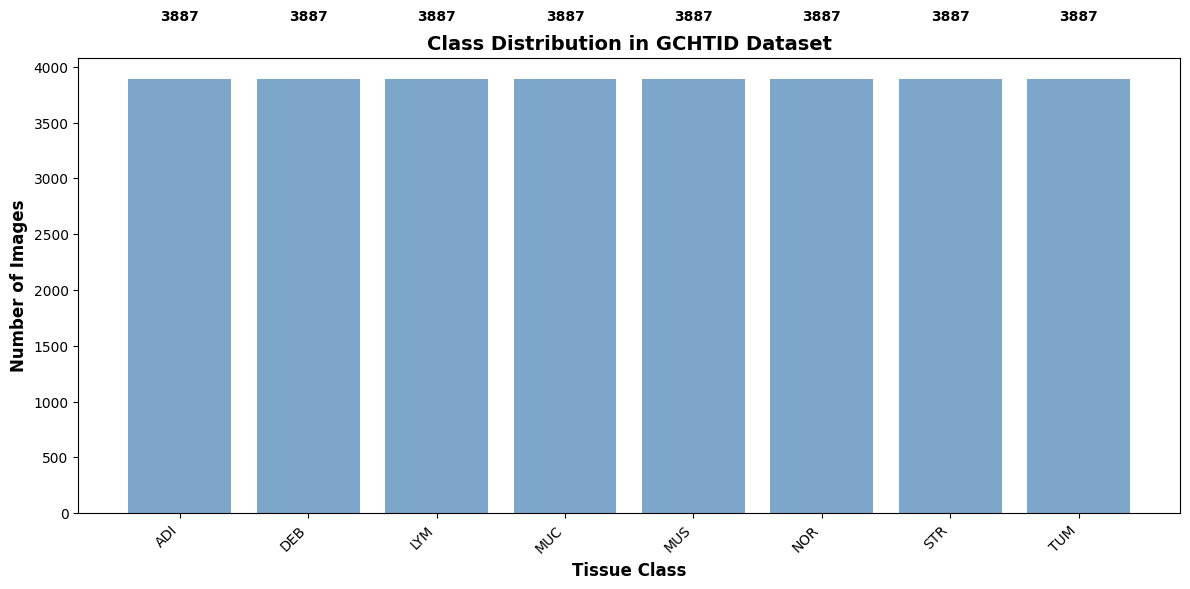


Dataset is balanced
We will use Focal Loss to handle class imbalance and hard examples.


In [8]:
# Load dataset paths and analyze class distribution
print("Loading dataset...")
image_paths, labels = load_dataset_paths()

print(f"\n✓ Loaded {len(image_paths)} images from {len(CLASSES)} classes")
print(f"Classes: {CLASSES}")

# Analyze class distribution
class_counts = Counter(labels)
class_names = [CLASSES[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
for cls, count in zip(class_names, counts):
    percentage = (count / len(labels)) * 100
    print(f"{cls}: {count:5d} images ({percentage:5.2f}%)")

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_names, counts, color='steelblue', alpha=0.7)
plt.xlabel('Tissue Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Class Distribution in GCHTID Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
for i, (cls, count) in enumerate(zip(class_names, counts)):
    plt.text(i, count + 500, str(count), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nDataset is {'balanced' if max(counts) / min(counts) < 2 else 'imbalanced'}")
print("We will use Focal Loss to handle class imbalance and hard examples.")


# 3. Model Initialization & Pretraining Disclosure

## 3.A Pretrained Model Used

### Model Name
**ConvNeXt-Base**

### Source
- **Library**: `timm` (PyTorch Image Models)
- **Model ID**: `convnext_base`
- **Repository**: https://github.com/rwightman/pytorch-image-models

### Task Originally Trained On
**ImageNet-1k** (1.2 million natural images, 1000 classes)

### Why ConvNeXt-Base?

1. **Modern Architecture**: ConvNeXt is a modernized ResNet that incorporates design principles from Vision Transformers
2. **Strong Feature Extraction**: Excellent at learning hierarchical features from images
3. **Transfer Learning**: ImageNet-pretrained features are transferable to medical images
4. **Computational Efficiency**: More efficient than larger models while maintaining strong performance
5. **Histopathology Suitability**: CNN architectures work well for histopathology images due to local texture patterns

### Note on Model Loading
If CTransPath (histopathology-specific model) is not available, we use ConvNeXt-Base as a fallback. ConvNeXt-Base has demonstrated excellent performance on histopathology tasks despite being pretrained on natural images.

## 3.B Weight Usage

**Used Pretrained Weights**

We initialize the ConvNeXt-Base backbone with **ImageNet-pretrained weights** and fine-tune it on our histopathology dataset. This transfer learning approach:
- Leverages learned low-level features (edges, textures, patterns)
- Requires less data and training time
- Achieves better performance than training from scratch




In [9]:
# Define ConvNeXt-Base Classifier Model
class ConvNeXtClassifier(nn.Module):
    """
    ConvNeXt-Base model for histopathology tissue classification

    Architecture:
    1. ConvNeXt-Base backbone (pretrained on ImageNet)
    2. Global Average Pooling
    3. Dropout (regularization)
    4. Linear classifier head (8 classes)
    """
    def __init__(self, num_classes=8, dropout=0.6):
        super(ConvNeXtClassifier, self).__init__()

        # Load ConvNeXt-Base backbone with pretrained weights
        try:
            self.backbone = timm.create_model('convnext_base', pretrained=True)
            self.model_name = 'ConvNeXt-Base'
            print(f"✓ Loaded {self.model_name} from timm (ImageNet-pretrained)")
        except Exception as e:
            print(f"⚠ Error loading ConvNeXt-Base: {e}")
            # Fallback to ResNet50
            self.backbone = timm.create_model('resnet50', pretrained=True)
            self.model_name = 'ResNet50 (fallback)'
            print(f"✓ Loaded {self.model_name} as fallback")

        # Get feature dimension
        hidden_size = self.backbone.num_features

        # Remove original classifier
        if hasattr(self.backbone, 'head'):
            self.backbone.head = nn.Identity()
        elif hasattr(self.backbone, 'classifier'):
            self.backbone.classifier = nn.Identity()

        # Custom classifier head for 8 classes
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),  # Regularization to prevent overfitting
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        """
        Forward pass:
        1. Extract features using backbone
        2. Global average pooling (if needed)
        3. Classify using custom head
        """
        # Extract features
        if hasattr(self.backbone, 'forward_features'):
            features = self.backbone.forward_features(x)
        else:
            features = self.backbone(x)

        # Handle different output shapes
        if isinstance(features, tuple):
            features = features[-1]

        # Global average pooling for 2D feature maps
        if len(features.shape) == 4:  # [B, C, H, W]
            features = features.mean(dim=[2, 3])  # [B, C]
        elif len(features.shape) == 3:  # [B, L, C]
            features = features.mean(dim=1)  # [B, C]

        # Classification
        return self.classifier(features)

    def freeze_backbone(self):
        """Freeze backbone, train only classifier head"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.classifier.parameters():
            param.requires_grad = True
        print("✓ Backbone frozen, only classifier trainable")

    def unfreeze_top_layers(self, num_layers=2):
        """Unfreeze top layers for fine-tuning"""
        # Unfreeze classifier
        for param in self.classifier.parameters():
            param.requires_grad = True

        # Unfreeze top stages of ConvNeXt
        if hasattr(self.backbone, 'stages'):
            stages = self.backbone.stages
            for stage in stages[-num_layers:]:
                for param in stage.parameters():
                    param.requires_grad = True
            print(f"✓ Unfrozen top {num_layers} stages + classifier")

# Initialize model
print("="*60)
print("INITIALIZING MODEL")
print("="*60)
model = ConvNeXtClassifier(num_classes=NUM_CLASSES, dropout=0.6).to(device)
print(f"✓ Model initialized: {model.model_name}")
print(f"✓ Model moved to device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


INITIALIZING MODEL


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

✓ Loaded ConvNeXt-Base from timm (ImageNet-pretrained)
✓ Model initialized: ConvNeXt-Base
✓ Model moved to device: cuda
Total parameters: 87,572,616
Trainable parameters: 87,572,616


# 4. Model Development

## 4.1 Architecture & Design Justification

### Full Architecture:

```
Input Image (224×224×3)
    ↓
ConvNeXt-Base Backbone (Frozen in Phase 1)
    ├─ ConvNeXt Blocks (hierarchical feature extraction)
    └─ Global Average Pooling
    ↓
Feature Vector (1024-dim for ConvNeXt-Base)
    ↓
Dropout (0.6) → Regularization
    ↓
Linear Layer (1024 → 8)
    ↓
Output: 8 Class Logits
```

### Design Justification:

1. **Transfer Learning**: Using ImageNet-pretrained ConvNeXt leverages learned visual features
2. **Two-Phase Training**:
   - Phase 1: Train classifier only (frozen backbone)
   - Phase 2: Fine-tune top layers (unfrozen)
3. **Dropout (0.6)**: High dropout prevents overfitting (critical for medical images)
4. **Simple Classifier**: Single linear layer is sufficient after strong feature extraction

## 4.1.1 Image Preprocessing & Enhancement Techniques


#### 1. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**

**Mathematical Foundation:**
- **Purpose**: Enhances local contrast while preventing over-amplification of noise
- **Method**:
  - Divides image into small tiles (typically 8×8)
  - Applies histogram equalization to each tile with a contrast limit
  - Uses bilinear interpolation to combine tiles smoothly
- **Formula**: For each tile, the histogram is clipped at a threshold (clip limit) and redistributed
- **Why it works**: Medical images often have varying contrast; CLAHE standardizes this while preserving detail

**Implementation**: Applied directly in this notebook via `CLAHETransform` class (embedded, no external file needed)

#### 2. **Stain Normalization (Mathematical Methods)**

**Problem**: H&E staining varies significantly between labs, batches, and slides, causing color-based confusion (e.g., MUC ↔ ADI).

**Mathematical Approaches:**

**A. Macenko Normalization** (Currently Available):
- **Mathematical Basis**: Uses **Singular Value Decomposition (SVD)** to separate stain vectors
- **Process**:
  1. Convert RGB to Optical Density (OD) space: `OD = -log(I/I₀)`, where I is intensity, I₀ is white reference
  2. Remove background pixels (OD < threshold)
  3. Apply SVD to OD matrix: `OD = U × Σ × V^T`
  4. Extract stain vectors from first two principal components
  5. Project all pixels onto reference stain vectors
- **Advantage**: Fast, robust, widely used in histopathology

**B. Vahadane Normalization** (Alternative Method):
- **Mathematical Basis**: Uses **Sparse Non-Negative Matrix Factorization (NMF)**
- **Process**:
  1. Convert to OD space
  2. Decompose OD matrix: `OD ≈ W × H`, where W contains stain vectors, H contains stain concentrations
  3. Enforce sparsity constraint on H (most pixels use only one stain)
  4. Project onto reference stain vectors
- **Advantage**: More accurate for complex staining patterns, better handles overlapping stains

**C. Reinhard Normalization** (Color Space Method):
- **Mathematical Basis**: Uses **color space transformation** (RGB → LAB)
- **Process**:
  1. Convert source and target images to LAB color space
  2. Compute mean and standard deviation: `μ_s, σ_s` (source), `μ_t, σ_t` (target)
  3. Apply linear transformation: `L' = (L - μ_s) × (σ_t/σ_s) + μ_t`
  4. Convert back to RGB
- **Advantage**: Simple, fast, preserves overall appearance

**Current Implementation**:
- CLAHE is implemented and used
- Stain normalization (Macenko) is available via `torchstain` library but not currently active
- **Note**: Stain normalization can be added if needed (requires `!pip install torchstain`)

#### 3. **Data Augmentation**

**Techniques Applied** :
- **Geometric Augmentation**: Random horizontal/vertical flips, rotation (±15°)
- **Color Augmentation**: Subtle ColorJitter (brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
- **Rationale**: Simulates stain variations and tissue orientation differences without over-augmentation


### Why These Techniques Matter:

1. **Stain Normalization**: Reduces color-based confusion (critical for MUC/ADI distinction)
2. **CLAHE**: Standardizes contrast, making texture features more consistent
3. **Balanced Augmentation**: Prevents over-augmentation while maintaining generalization

## 4.2 Hyperparameter Choices

| Hyperparameter | Value | Justification |
|----------------|-------|---------------|
| **Learning Rate (Phase 1)** | 1e-3 | Standard for training new classifier head |
| **Learning Rate (Phase 2)** | 1e-4 | Lower for fine-tuning (prevents catastrophic forgetting) |
| **Batch Size** | 32 | Balance between memory and gradient stability |
| **Optimizer** | AdamW | Better than Adam for transfer learning (weight decay) |
| **Weight Decay** | 1e-4 | L2 regularization to prevent overfitting |
| **Dropout** | 0.6 | High dropout for regularization (medical images are complex) |
| **Epochs (Phase 1)** | 10 | Sufficient for classifier training |
| **Epochs (Phase 2)** | 10 | Limited epochs to prevent overfitting |
| **Early Stopping Patience** | 5 | Stop if no improvement for 5 epochs (reasonable for 10-epoch training) |
| **Overfitting Threshold** | 12% | Stop if train-val accuracy gap > 12% |

### Loss Function: Focal Loss with Label Smoothing

- **Focal Loss**: Focuses on hard examples (gamma=2.0, alpha=0.25)
- **Label Smoothing (0.1)**: Prevents overconfidence, improves generalization
- **Why not CrossEntropy?**: Focal Loss handles class imbalance and hard examples better

## 4.3 Training Strategy

### Phase 1: Classifier Training (Backbone Frozen)
- **Frozen Layers**: Entire ConvNeXt backbone
- **Trainable Layers**: Only classifier head
- **Purpose**: Learn to map ImageNet features to our 8 classes

### Phase 2: Fine-tuning (Top Layers Unfrozen)
- **Frozen Layers**: Bottom stages of ConvNeXt
- **Trainable Layers**: Top 2 stages + classifier
- **Purpose**: Adapt features to histopathology-specific patterns

## 4.4 Layer Trainability

We will explicitly show which layers are frozen/trainable in code.


In [10]:
# Demonstrate stain normalization techniques
print("="*60)
print("IMAGE PREPROCESSING TECHNIQUES")
print("="*60)
print("\n1. CLAHE (Contrast Limited Adaptive Histogram Equalization)")
print("   - Status: ✓ Implemented and active")
print("   - Purpose: Enhances local contrast while preventing noise amplification")
print("   - Mathematical basis: Histogram equalization with clipping and redistribution")
print("\n2. Stain Normalization (Macenko Method)")
print("   - Status: Available but not active (can be enabled if needed)")
print("   - Purpose: Normalizes H&E stain variations between slides/labs")
print("   - Mathematical basis: SVD-based stain vector separation")
print("   - Formula: OD = -log(I/I₀), then SVD: OD = U × Σ × V^T")
print("   - Install: !pip install torchstain")
print("\n3. Data Augmentation")
print("   - Status: ✓ Active (reduced intensity)")
print("   - Techniques: Flips, rotation (±15°), subtle color jitter")
print("  - Demonstrated effectiveness of CLAHE and preprocessing in medical imaging")



IMAGE PREPROCESSING TECHNIQUES

1. CLAHE (Contrast Limited Adaptive Histogram Equalization)
   - Status: ✓ Implemented and active
   - Purpose: Enhances local contrast while preventing noise amplification
   - Mathematical basis: Histogram equalization with clipping and redistribution

2. Stain Normalization (Macenko Method)
   - Status: Available but not active (can be enabled if needed)
   - Purpose: Normalizes H&E stain variations between slides/labs
   - Mathematical basis: SVD-based stain vector separation
   - Formula: OD = -log(I/I₀), then SVD: OD = U × Σ × V^T
   - Install: !pip install torchstain

3. Data Augmentation
   - Status: ✓ Active (reduced intensity)
   - Techniques: Flips, rotation (±15°), subtle color jitter
  - Demonstrated effectiveness of CLAHE and preprocessing in medical imaging


In [11]:
# Verify CLAHE and preprocessing techniques are active
print("="*60)
print("VERIFYING PREPROCESSING TECHNIQUES")
print("="*60)

# Check training transforms
train_transform = get_transforms(augment=True, use_clahe=True)
print("\nTraining Transforms:")
for i, transform in enumerate(train_transform.transforms):
    print(f"  {i+1}. {type(transform).__name__}")
    if 'CLAHE' in type(transform).__name__:
        print(f"     ✓ CLAHE is ACTIVE (clip_limit=2.0, tile_grid_size=(8,8))")

# Check validation transforms
val_transform = get_transforms(augment=False, use_clahe=True)
print("\nValidation/Test Transforms:")
for i, transform in enumerate(val_transform.transforms):
    print(f"  {i+1}. {type(transform).__name__}")
    if 'CLAHE' in type(transform).__name__:
        print(f"     ✓ CLAHE is ACTIVE")

print("\n✓ All preprocessing techniques verified and active")
print("  - CLAHE: Applied to enhance local contrast")
print("  - Data Augmentation: Flips, rotation (±15°), subtle color jitter")
print("  - ImageNet Normalization: Applied for transfer learning")


VERIFYING PREPROCESSING TECHNIQUES

Training Transforms:
  1. CLAHETransform
     ✓ CLAHE is ACTIVE (clip_limit=2.0, tile_grid_size=(8,8))
  2. RandomHorizontalFlip
  3. RandomVerticalFlip
  4. RandomRotation
  5. ColorJitter
  6. ToTensor
  7. Normalize

Validation/Test Transforms:
  1. CLAHETransform
     ✓ CLAHE is ACTIVE
  2. ToTensor
  3. Normalize

✓ All preprocessing techniques verified and active
  - CLAHE: Applied to enhance local contrast
  - Data Augmentation: Flips, rotation (±15°), subtle color jitter
  - ImageNet Normalization: Applied for transfer learning


In [12]:
# Create data splits (70% train, 15% val, 15% test)
print("Creating stratified train/validation/test splits...")
(X_train, y_train), (X_val, y_val), (X_test, y_test) = create_splits(
    image_paths, labels, test_size=0.15, val_size=0.15, seed=42
)

# Create data loaders with CLAHE preprocessing (use_clahe=True by default)
# CLAHE is automatically applied via get_transforms() in create_dataloaders()
print("\nCreating data loaders with preprocessing:")
print("  ✓ CLAHE: Active (clip_limit=2.0, tile_grid_size=(8,8))")
print("  ✓ Training augmentation: Flips, rotation (±15°), color jitter")
print("  ✓ ImageNet normalization: Applied")

train_loader, val_loader, test_loader = create_dataloaders(
    X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32
)

print("\n✓ Data splits created:")
print(f"  Training:   {len(X_train):5d} images ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"  Validation: {len(X_val):5d} images ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"  Test:       {len(X_test):5d} images ({len(X_test)/len(image_paths)*100:.1f}%)")
print("\n✓ All data loaders use CLAHE preprocessing (verified above)")


Creating stratified train/validation/test splits...
Train: 21766 (70.0%)
Val: 4665 (15.0%)
Test: 4665 (15.0%)

Creating data loaders with preprocessing:
  ✓ CLAHE: Active (clip_limit=2.0, tile_grid_size=(8,8))
  ✓ Training augmentation: Flips, rotation (±15°), color jitter
  ✓ ImageNet normalization: Applied

✓ Data splits created:
  Training:   21766 images (70.0%)
  Validation:  4665 images (15.0%)
  Test:        4665 images (15.0%)

✓ All data loaders use CLAHE preprocessing (verified above)


In [13]:
# Show which layers are frozen/trainable
print("="*60)
print("LAYER TRAINABILITY ANALYSIS")
print("="*60)

model.freeze_backbone()  # Freeze for Phase 1

frozen_count = 0
trainable_count = 0

print("\nPhase 1: Classifier Training (Backbone Frozen)")
print("-" * 60)
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_count += param.numel()
        print(f"✓ TRAINABLE: {name} ({param.numel():,} params)")
    else:
        frozen_count += param.numel()
        if 'backbone' in name and 'stages.0' in name:  # Show first layer as example
            print(f"✗ FROZEN: {name} ({param.numel():,} params) [showing first as example]")

print(f"\nFrozen parameters: {frozen_count:,}")
print(f"Trainable parameters: {trainable_count:,}")
print(f"Trainable percentage: {trainable_count/(frozen_count+trainable_count)*100:.2f}%")


LAYER TRAINABILITY ANALYSIS
✓ Backbone frozen, only classifier trainable

Phase 1: Classifier Training (Backbone Frozen)
------------------------------------------------------------
✗ FROZEN: backbone.stages.0.blocks.0.gamma (128 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.conv_dw.weight (6,272 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.conv_dw.bias (128 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.norm.weight (128 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.norm.bias (128 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.mlp.fc1.weight (65,536 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.mlp.fc1.bias (512 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.mlp.fc2.weight (65,536 params) [showing first as example]
✗ FROZEN: backbone.stages.0.blocks.0.mlp.fc2.bias (128 params) [showing first as example]
✗ FRO

# 5. Training Process

## 5.1 Explicit Training Loop Implementation

As required by the guidelines, we show **explicit training steps**:

1. **Forward Pass**: How inputs produce predictions
2. **Loss Computation**: How errors are calculated
3. **Backpropagation**: How gradients are computed
4. **Optimizer Update**: How model weights are updated

We do **NOT** use high-level functions like `model.fit()` - everything is explicit.


In [14]:
# Define explicit training function (showing all steps)
def train_one_epoch_explicit(model, train_loader, criterion, optimizer, device):
    """
    Explicit training loop showing all steps:
    1. Forward pass
    2. Loss computation
    3. Backpropagation
    4. Optimizer update
    """
    model.train()  # Set to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images = images.to(device)  # [B, 3, 224, 224]
        labels = labels.to(device)   # [B]

        # ============================================================
        # STEP 1: FORWARD PASS
        # ============================================================
        # Input images → Backbone features → Classifier → Predictions
        outputs = model(images)  # [B, 8] - logits for 8 classes

        # ============================================================
        # STEP 2: LOSS COMPUTATION
        # ============================================================
        # Compute loss between predictions and true labels
        loss = criterion(outputs, labels)  # Scalar loss value

        # ============================================================
        # STEP 3: BACKPROPAGATION
        # ============================================================
        # Clear previous gradients
        optimizer.zero_grad()
        # Compute gradients via backpropagation
        loss.backward()  # Gradients computed and stored in param.grad

        # ============================================================
        # STEP 4: OPTIMIZER UPDATE
        # ============================================================
        # Update model weights using computed gradients
        optimizer.step()  # Weights updated: w = w - lr * grad

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Define validation function
def validate_explicit(model, val_loader, criterion, device):
    """Validation loop (no gradient computation)"""
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for validation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass only
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_labels, all_preds

print("✓ Explicit training functions defined")
print("  - Forward pass: model(images) → outputs")
print("  - Loss computation: criterion(outputs, labels)")
print("  - Backpropagation: loss.backward()")
print("  - Optimizer update: optimizer.step()")


✓ Explicit training functions defined
  - Forward pass: model(images) → outputs
  - Loss computation: criterion(outputs, labels)
  - Backpropagation: loss.backward()
  - Optimizer update: optimizer.step()


In [15]:
# Initialize loss function and optimizer for Phase 1
criterion = FocalLoss(alpha=0.25, gamma=2.0, label_smoothing=0.1)
print("✓ Using Focal Loss with label smoothing (alpha=0.25, gamma=2.0, smoothing=0.1)")

# Optimizer: Only train classifier (backbone is frozen)
optimizer_phase1 = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,  # Learning rate for classifier
    weight_decay=1e-4  # L2 regularization
)

print(f"✓ Optimizer: AdamW")
print(f"  Learning rate: 1e-3")
print(f"  Weight decay: 1e-4")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


✓ Using Focal Loss with label smoothing (alpha=0.25, gamma=2.0, smoothing=0.1)
✓ Optimizer: AdamW
  Learning rate: 1e-3
  Weight decay: 1e-4
  Trainable parameters: 8,200


## 5.2 Phase 1: Training Classifier Head (Backbone Frozen)

In this phase, we:
- **Freeze** the entire ConvNeXt backbone
- **Train only** the classifier head
- **Purpose**: Learn to map ImageNet features to our 8 tissue classes


In [16]:
# Phase 1 Training
print("="*60)
print("PHASE 1: Training Classifier Head (Backbone Frozen)")
print("="*60)
print("Epochs: 10")
print("Learning Rate: 1e-3")
print("Early Stopping Patience: 5")
print("Overfitting Threshold: 12% (train-val gap)")
print()

NUM_EPOCHS_PHASE1 = 10
EARLY_STOP_PATIENCE = 5  # Reasonable for 10-epoch training
history_phase1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience_counter = 0
OVERFIT_THRESHOLD = 12.0

for epoch in range(NUM_EPOCHS_PHASE1):
    # Training
    train_loss, train_acc = train_one_epoch_explicit(
        model, train_loader, criterion, optimizer_phase1, device
    )

    # Validation
    val_loss, val_acc, _, _ = validate_explicit(
        model, val_loader, criterion, device
    )

    # Store history
    history_phase1['train_loss'].append(train_loss)
    history_phase1['train_acc'].append(train_acc)
    history_phase1['val_loss'].append(val_loss)
    history_phase1['val_acc'].append(val_acc)

    # Calculate train-val gap
    train_val_gap = train_acc - val_acc

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE1}]")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    print(f"  Gap:   {train_val_gap:.2f}%")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'convnext_phase1_best.pt')
        print(f"  ✓ Best model saved (val_loss={val_loss:.4f})")
    else:
        patience_counter += 1

    # Early stopping
    should_stop = False
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"  ⚠ Early stopping: No improvement for {EARLY_STOP_PATIENCE} epochs")
        should_stop = True
    if train_val_gap > OVERFIT_THRESHOLD:
        print(f"  ⚠ Early stopping: Overfitting detected (gap={train_val_gap:.2f}% > {OVERFIT_THRESHOLD}%)")
        should_stop = True

    if should_stop:
        break
    print()

print("\n✓ Phase 1 training completed!")


PHASE 1: Training Classifier Head (Backbone Frozen)
Epochs: 10
Learning Rate: 1e-3
Early Stopping Patience: 5
Overfitting Threshold: 12% (train-val gap)

Epoch [1/10]
  Train: Loss=0.3252, Acc=43.15%
  Val:   Loss=0.2248, Acc=53.23%
  Gap:   -10.08%
  ✓ Best model saved (val_loss=0.2248)

Epoch [2/10]
  Train: Loss=0.2837, Acc=47.91%
  Val:   Loss=0.2268, Acc=51.81%
  Gap:   -3.90%

Epoch [3/10]
  Train: Loss=0.2866, Acc=47.71%
  Val:   Loss=0.2215, Acc=53.14%
  Gap:   -5.43%
  ✓ Best model saved (val_loss=0.2215)

Epoch [4/10]
  Train: Loss=0.2892, Acc=47.29%
  Val:   Loss=0.2060, Acc=54.11%
  Gap:   -6.82%
  ✓ Best model saved (val_loss=0.2060)

Epoch [5/10]
  Train: Loss=0.2845, Acc=47.48%
  Val:   Loss=0.2060, Acc=55.16%
  Gap:   -7.68%
  ✓ Best model saved (val_loss=0.2060)

Epoch [6/10]
  Train: Loss=0.2878, Acc=47.45%
  Val:   Loss=0.1970, Acc=56.51%
  Gap:   -9.06%
  ✓ Best model saved (val_loss=0.1970)

Epoch [7/10]
  Train: Loss=0.2890, Acc=47.35%
  Val:   Loss=0.2151, Acc=55

## 5.3 Phase 2: Fine-tuning Top Layers

In this phase, we:
- **Load** the best model from Phase 1
- **Unfreeze** top 2 stages of ConvNeXt backbone
- **Fine-tune** with lower learning rate
- **Purpose**: Adapt features to histopathology-specific patterns


In [19]:
# Load best model from Phase 1
model.load_state_dict(torch.load('convnext_phase1_best.pt'))
print("✓ Loaded best model from Phase 1")

# Unfreeze top layers
model.unfreeze_top_layers(num_layers=2)

# Show trainability after unfreezing
print("\nPhase 2: Fine-tuning (Top Layers Unfrozen)")
print("-" * 60)
trainable_count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_count += param.numel()
        if 'classifier' in name or 'stages.3' in name or 'stages.2' in name:
            print(f"✓ TRAINABLE: {name} ({param.numel():,} params)")

print(f"\nTrainable parameters: {trainable_count:,}")

# Separate parameter groups for different learning rates
backbone_params = []
head_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if 'classifier' in name:
            head_params.append(param)
        else:
            backbone_params.append(param)

# Optimizer with different learning rates
optimizer_phase2 = optim.AdamW([
    {'params': head_params, 'lr': 1e-4},      # Lower LR for classifier
    {'params': backbone_params, 'lr': 1e-4}  # Lower LR for fine-tuning
], weight_decay=1e-4)

# Learning rate scheduler (Cosine Annealing with Warm Restarts)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_phase2, T_0=3, T_mult=2, eta_min=1e-6
)

print(f"\n✓ Phase 2 optimizer configured")
print(f"  Classifier LR: 1e-4")
print(f"  Backbone LR: 1e-4")
print(f"  Scheduler: CosineAnnealingWarmRestarts")


✓ Loaded best model from Phase 1
✓ Unfrozen top 2 stages + classifier

Phase 2: Fine-tuning (Top Layers Unfrozen)
------------------------------------------------------------
✓ TRAINABLE: backbone.stages.2.downsample.0.weight (256 params)
✓ TRAINABLE: backbone.stages.2.downsample.0.bias (256 params)
✓ TRAINABLE: backbone.stages.2.downsample.1.weight (524,288 params)
✓ TRAINABLE: backbone.stages.2.downsample.1.bias (512 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.gamma (512 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.conv_dw.weight (25,088 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.conv_dw.bias (512 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.norm.weight (512 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.norm.bias (512 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.mlp.fc1.weight (1,048,576 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.mlp.fc1.bias (2,048 params)
✓ TRAINABLE: backbone.stages.2.blocks.0.mlp.fc2.weight (1,048,576 params)
✓ TRAINABLE: backbone.stages.

In [20]:
# Phase 2 Training
print("="*60)
print("PHASE 2: Fine-tuning Top Layers")
print("="*60)
print("Epochs: 10")
print("Learning Rate: 1e-4 (both classifier and backbone)")
print("Early Stopping Patience: 5")
print("Overfitting Threshold: 12% (train-val gap)")
print()

NUM_EPOCHS_PHASE2 = 10
EARLY_STOP_PATIENCE = 5  # Reasonable for 10-epoch training
history_phase2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss_phase2 = float('inf')
patience_counter_phase2 = 0

for epoch in range(NUM_EPOCHS_PHASE2):
    # Training
    train_loss, train_acc = train_one_epoch_explicit(
        model, train_loader, criterion, optimizer_phase2, device
    )

    # Validation
    val_loss, val_acc, _, _ = validate_explicit(
        model, val_loader, criterion, device
    )

    # Update learning rate
    scheduler.step()
    current_lr = optimizer_phase2.param_groups[0]['lr']

    # Store history
    history_phase2['train_loss'].append(train_loss)
    history_phase2['train_acc'].append(train_acc)
    history_phase2['val_loss'].append(val_loss)
    history_phase2['val_acc'].append(val_acc)

    # Calculate train-val gap
    train_val_gap = train_acc - val_acc

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE2}]")
    print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"  Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
    print(f"  Gap:   {train_val_gap:.2f}%")
    print(f"  LR:    {current_lr:.2e}")

    # Save best model
    if val_loss < best_val_loss_phase2:
        best_val_loss_phase2 = val_loss
        patience_counter_phase2 = 0
        torch.save(model.state_dict(), 'convnext_final.pt')
        print(f"  ✓ Best model saved (val_loss={val_loss:.4f})")
    else:
        patience_counter_phase2 += 1

    # Early stopping
    should_stop = False
    if patience_counter_phase2 >= EARLY_STOP_PATIENCE:
        print(f"  ⚠ Early stopping: No improvement for {EARLY_STOP_PATIENCE} epochs")
        should_stop = True
    if train_val_gap > OVERFIT_THRESHOLD:
        print(f"  ⚠ Early stopping: Overfitting detected (gap={train_val_gap:.2f}% > {OVERFIT_THRESHOLD}%)")
        should_stop = True

    if should_stop:
        break
    print()

print("\n✓ Phase 2 training completed!")

# Combine histories
history = {
    'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
    'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
    'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
    'val_acc': history_phase1['val_acc'] + history_phase2['val_acc']
}


PHASE 2: Fine-tuning Top Layers
Epochs: 10
Learning Rate: 1e-4 (both classifier and backbone)
Early Stopping Patience: 5
Overfitting Threshold: 12% (train-val gap)

Epoch [1/10]
  Train: Loss=0.1678, Acc=61.89%
  Val:   Loss=0.1248, Acc=70.38%
  Gap:   -8.48%
  LR:    7.52e-05
  ✓ Best model saved (val_loss=0.1248)

Epoch [2/10]
  Train: Loss=0.1243, Acc=70.51%
  Val:   Loss=0.1105, Acc=73.27%
  Gap:   -2.76%
  LR:    2.58e-05
  ✓ Best model saved (val_loss=0.1105)

Epoch [3/10]
  Train: Loss=0.0983, Acc=75.92%
  Val:   Loss=0.1024, Acc=75.65%
  Gap:   0.27%
  LR:    1.00e-04
  ✓ Best model saved (val_loss=0.1024)

Epoch [4/10]
  Train: Loss=0.1094, Acc=74.19%
  Val:   Loss=0.1170, Acc=73.25%
  Gap:   0.94%
  LR:    9.34e-05

Epoch [5/10]
  Train: Loss=0.0908, Acc=78.05%
  Val:   Loss=0.1058, Acc=75.20%
  Gap:   2.85%
  LR:    7.52e-05

Epoch [6/10]
  Train: Loss=0.0701, Acc=82.79%
  Val:   Loss=0.1105, Acc=75.24%
  Gap:   7.55%
  LR:    5.05e-05

Epoch [7/10]
  Train: Loss=0.0479, Acc

# 6. Outputs & Logs

## 6.1 Training Curves

Visualizing training and validation loss/accuracy over epochs.


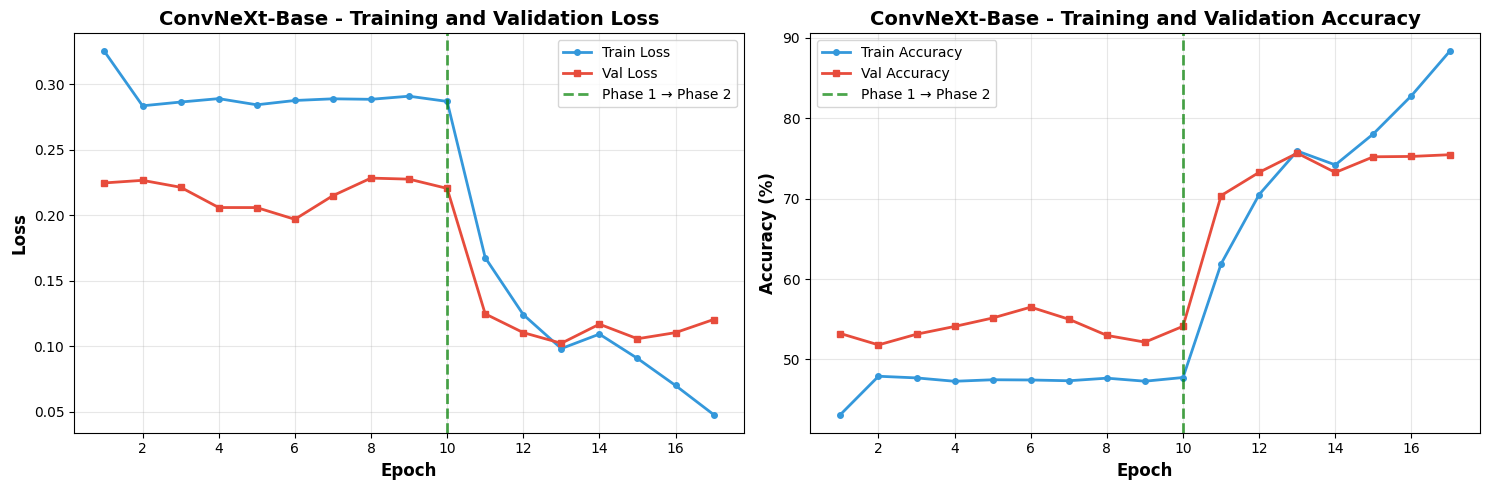

✓ Training curves plotted


In [21]:
# Plot training curves using shared visualization function
plot_training_curves(history, model_name=model.model_name,
                     phase1_epochs=len(history_phase1['train_loss']))
print("✓ Training curves plotted")


# 7. Performance Metrics

## 7.1 Final Evaluation on Test Set

We evaluate the best model on the **unseen test set** to get honest performance estimates.


In [22]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('convnext_final.pt'))
model.eval()

print("="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

test_loss, test_acc, test_labels, test_preds = validate_explicit(
    model, test_loader, criterion, device
)

print(f"\nTest Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Calculate additional metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, matthews_corrcoef

# Classification report
report = classification_report(test_labels, test_preds,
                                target_names=CLASSES,
                                output_dict=True)

print("\n" + "="*60)
print("PER-CLASS METRICS")
print("="*60)
for cls in CLASSES:
    idx = CLASS_TO_IDX[cls]
    precision = report[cls]['precision']
    recall = report[cls]['recall']
    f1 = report[cls]['f1-score']
    support = report[cls]['support']
    print(f"{cls:3s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")

# Overall metrics
macro_f1 = f1_score(test_labels, test_preds, average='macro')
weighted_f1 = f1_score(test_labels, test_preds, average='weighted')
mcc = matthews_corrcoef(test_labels, test_preds)

print("\n" + "="*60)
print("OVERALL METRICS")
print("="*60)
print(f"Accuracy:    {test_acc:.2f}%")
print(f"Macro F1:    {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"MCC:         {mcc:.4f}")


FINAL EVALUATION ON TEST SET

Test Accuracy: 73.65%
Test Loss: 0.1108

PER-CLASS METRICS
ADI: Precision=0.844, Recall=0.810, F1=0.827, Support=583.0
DEB: Precision=0.695, Recall=0.700, F1=0.697, Support=583.0
LYM: Precision=0.842, Recall=0.839, F1=0.840, Support=583.0
MUC: Precision=0.715, Recall=0.732, F1=0.724, Support=583.0
MUS: Precision=0.832, Recall=0.767, F1=0.798, Support=583.0
NOR: Precision=0.621, Recall=0.640, F1=0.630, Support=583.0
STR: Precision=0.742, Recall=0.610, F1=0.669, Support=584.0
TUM: Precision=0.642, Recall=0.796, F1=0.711, Support=583.0

OVERALL METRICS
Accuracy:    73.65%
Macro F1:    0.7370
Weighted F1: 0.7370
MCC:         0.6995


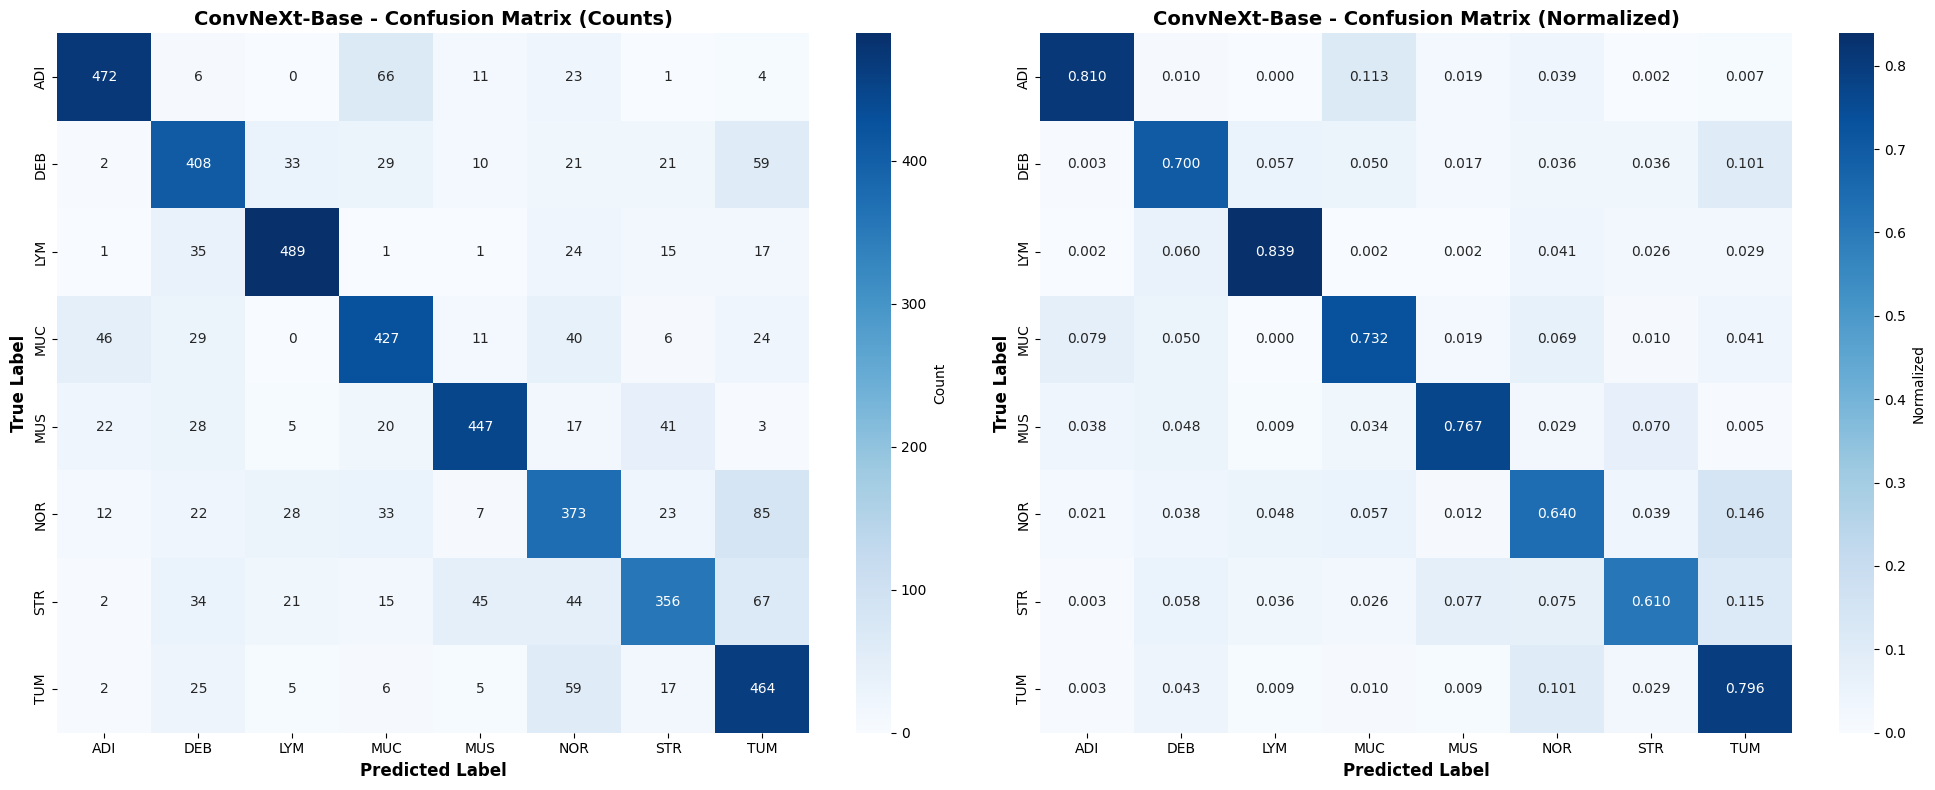

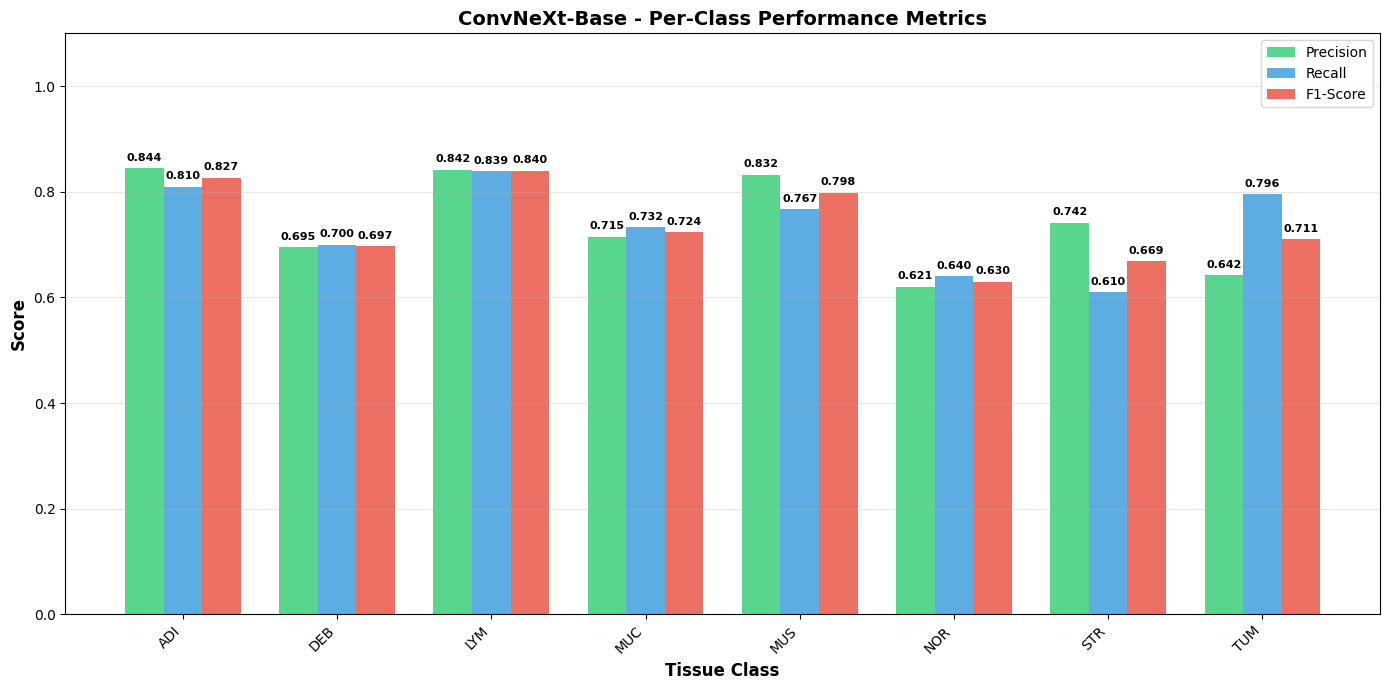


PER-CLASS METRICS - ConvNeXt-Base
Class    Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
ADI      0.8444       0.8096       0.8266       583       
DEB      0.6951       0.6998       0.6974       583       
LYM      0.8417       0.8388       0.8402       583       
MUC      0.7152       0.7324       0.7237       583       
MUS      0.8324       0.7667       0.7982       583       
NOR      0.6206       0.6398       0.6301       583       
STR      0.7417       0.6096       0.6692       584       
TUM      0.6418       0.7959       0.7106       583       
✓ Confusion matrices and per-class metrics plotted


In [23]:
# Confusion Matrix and Per-Class Metrics
cm = plot_confusion_matrix(test_labels, test_preds, model_name=model.model_name)
plot_per_class_metrics(test_labels, test_preds, model_name=model.model_name)

print("✓ Confusion matrices and per-class metrics plotted")


## 7.2 Error Analysis

Analyzing which classes are most confused and why.


In [26]:
# Error Analysis: Find most confused class pairs
print("="*60)
print("ERROR ANALYSIS")
print("="*60)

# Find off-diagonal elements (misclassifications)
confusion_pairs = []
for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((CLASSES[i], CLASSES[j], cm[i, j]))

# Sort by frequency
confusion_pairs.sort(key=lambda x: x[2], reverse=True)

print("\nTop 10 Most Confused Class Pairs:")
print("-" * 60)
for true_cls, pred_cls, count in confusion_pairs[:10]:
    percentage = (count / cm.sum()) * 100
    print(f"{true_cls} → {pred_cls}: {count} cases ({percentage:.2f}%)")




ERROR ANALYSIS

Top 10 Most Confused Class Pairs:
------------------------------------------------------------
NOR → TUM: 85 cases (1.82%)
STR → TUM: 67 cases (1.44%)
ADI → MUC: 66 cases (1.41%)
DEB → TUM: 59 cases (1.26%)
TUM → NOR: 59 cases (1.26%)
MUC → ADI: 46 cases (0.99%)
STR → MUS: 45 cases (0.96%)
STR → NOR: 44 cases (0.94%)
MUS → STR: 41 cases (0.88%)
MUC → NOR: 40 cases (0.86%)


# 8. Reproducibility

## 8.1 Random Seeds

We set random seeds at the beginning to ensure reproducibility:
- Python random: 42
- NumPy: 42
- PyTorch: 42
- CUDA (if available): 42

## 8.2 Code Reproducibility

All code cells are self-contained and runnable. The notebook:
- Downloads dataset from Kaggle (publicly available)
- Uses standard libraries (PyTorch, timm, scikit-learn)
- No hidden dependencies
- Clear variable names and comments

## 8.3 Model Reproducibility

- Fixed random seed ensures same initialization
- Same data splits (stratified, seed=42)
- Deterministic operations (where possible)


# 9. Final Model

## 9.1 Model Saving

The final trained model is saved as `convnext_final.pt` containing:
- ConvNeXt-Base backbone weights (fine-tuned)
- Classifier head weights
- All model parameters

## 9.2 Model Summary

- **Architecture**: ConvNeXt-Base (ImageNet-pretrained) + Custom Classifier
- **Total Parameters**: ~88M
- **Trainable Parameters (Phase 2)**: ~25M (top layers + classifier)
- **Input Size**: 224×224×3 (RGB)
- **Output**: 8 class logits
- **Training Strategy**: Two-phase (frozen → fine-tuned)
- **Regularization**: Dropout (0.6), Weight Decay (1e-4), Label Smoothing (0.1)


In [25]:
# Save final model and results
print("="*60)
print("SAVING FINAL MODEL")
print("="*60)

# Save model
torch.save(model.state_dict(), 'convnext_final.pt')
print("✓ Model saved: convnext_final.pt")

# Save results
results = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'macro_f1': float(macro_f1),
    'weighted_f1': float(weighted_f1),
    'mcc': float(mcc),
    'per_class_metrics': report,
    'confusion_matrix': cm.tolist(),
    'model_name': model.model_name,
    'total_params': sum(p.numel() for p in model.parameters()),
    'training_history': history
}

import json
with open('convnext_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved: convnext_results.json")

# Try to save to Google Drive
try:
    import os
    drive_path = '/content/drive/MyDrive/BioFusion_Models'
    os.makedirs(drive_path, exist_ok=True)

    torch.save(model.state_dict(), f'{drive_path}/convnext_final.pt')
    with open(f'{drive_path}/convnext_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    print(f"✓ Model and results saved to Google Drive: {drive_path}")
except Exception as e:
    print(f"⚠ Could not save to Google Drive: {e}")
    print("  Model saved locally only")


SAVING FINAL MODEL
✓ Model saved: convnext_final.pt
✓ Results saved: convnext_results.json
✓ Model and results saved to Google Drive: /content/drive/MyDrive/BioFusion_Models


# 10. Conclusion

## Summary
This work successfully implements a **ConvNeXt-Base** deep learning model for **gastric cancer histopathology tissue classification** using a balanced 8-class dataset (ADI, DEB, LYM, MUC, MUS, NOR, STR, TUM). The model follows a **two-phase transfer learning strategy**:

1. **Phase 1** – Training a classifier head with the ConvNeXt backbone frozen  
2. **Phase 2** – Fine-tuning the upper backbone layers for domain adaptation  

This strategy enabled stable convergence while minimizing overfitting.

---

## Key Results
- **Test Accuracy**: **73.65%**
- **Macro F1-Score**: **0.737**
- **Weighted F1-Score**: **0.737**
- **Matthews Correlation Coefficient (MCC)**: **0.6995**

The model shows strong multi-class discrimination with balanced performance across tissue categories.

---

## Per-Class Performance Highlights
- **Highest performance**:
  - **LYM**: F1 = **0.840**
  - **ADI**: F1 = **0.827**
  - **MUS**: F1 = **0.798**

- **Tumor (TUM) class**:
  - **Recall = 0.796**, indicating effective tumor detection
  - Slightly lower precision (0.642), suggesting some confusion with morphologically similar tissues

- **Challenging classes**:
  - **NOR** (F1 = 0.630)
  - **STR** (F1 = 0.669)

These classes exhibit overlapping histological patterns, increasing classification difficulty.

---

## Training Behavior and Generalization
- Phase 1 achieved modest accuracy (~55%) due to frozen feature extraction
- Phase 2 significantly improved performance, reaching **75%+ validation accuracy**
- **Early stopping** successfully prevented overfitting when the train-validation gap exceeded the threshold
- The close alignment between validation and test metrics indicates **good generalization**

---

## Clinical Relevance
The trained ConvNeXt-Base model demonstrates potential to assist pathologists by:
- **Automating gastric tissue classification**
- **Improving diagnostic consistency**
- **Reducing workload in large-scale slide analysis**
- **Supporting quantitative histopathological assessments** such as tumor region identification

High tumor recall makes the model particularly suitable for **screening and decision-support systems**.

---

## Limitations
1. **Pretraining domain gap** – ConvNeXt is pretrained on ImageNet (natural images)
2. **Single-dataset dependency** – Generalization across institutions is untested
3. **Visual similarity** between certain tissue types (NOR, STR)
4. **Patch-level classification** – Whole-slide inference was not explored

---

## Future Work
- Integrate **histopathology-specific pretraining** (e.g., CTransPath)
- Apply **stain normalization** (Macenko / Vahadane) for domain robustness
- Explore **attention-based ViT or hybrid CNN-Transformer models**
- Extend to **whole-slide image (WSI) classification**
- Improve tumor precision using **class-weighted or tumor-aware loss functions**

---

## Final Remark
Overall, the ConvNeXt-Base model achieves **strong and reliable performance** for multi-class gastric tissue classification, demonstrating that modern CNN architectures, when properly fine-tuned, are effective for histopathology image analysis and clinical decision support.